In [1]:
!conda activate DS807

# Exam DS807

## Preparation of data

### Labeling Data and converting images to array values

In [2]:
#import packages for labelling and converting imagery data
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import asarray

In [3]:
##############
# Func for creating 1D image arrays

def load_image_function(path, question):

    images = [] # empty list placeholder
    labels = [] # empty list placeholder
    container = [] # container to validate correct labels

    for filename in os.listdir(path):
        container.append(filename) # add filename to container
        if question == 'q1':
            CCDY_img = load_img(path + f'/{filename}', target_size = (56, 106),
            color_mode="grayscale")                  
            CCDY_img = img_to_array(CCDY_img)
            images.append(CCDY_img) # append the photo to the images. The images list contains a list of arrays       
        else:
            CCDY_img = load_img(path + f'/{filename}', target_size = (56, 106))        
            CCDY_img = img_to_array(CCDY_img)
            images.append(CCDY_img) # append the photo to the images. The images list contains a list of arrays    

    return asarray(images), container; # not interested in list of arrays, but array containing lists. Asarray does this. Returns three arrays

In [4]:
################
# Func for creating df with classes and 3d img arrays

def load_img_data (question):
    # Start: creatign classes ons string_digits
    # load string digits

    #os.chdir(path_string_digits)

    string_digits = pd.read_csv('DIDA_12000_String_Digit_Labels.csv', 
                 header = None, 
                 names=["index", "string"])
    # create empty class columns
    string_digits['CC'] = 0
    string_digits['D'] = 0
    string_digits['Y'] = 0
    string_digits = string_digits.astype(str)
    # Iterate string digits and append classes
    for i, row in string_digits.iterrows():
        if len(row['string']) != 4:
            row['CC'] = '1'
            row['D'] = '10'
            row['Y'] = '10'
        else:
            row['D'] = row['string'][2]
            row['Y'] = row['string'][3]
            if row['string'][0:2] == '18':
                row['CC']='0'
            else:
                row['CC']='1'
    # End of class labeling on string_digits.
    #
    # Start: create img_df containing scaled images as 1D tensors
    # Convert imagery to 1D arrays with tagged file names

    #os.chdir(path_images)
    image_array, filename = load_image_function('DIDA_12000_String_Digit_Images/DIDA_1', question)

    # and convert to a img_df
    img_df = pd.DataFrame({'filename': filename, 'img_value': list(image_array)}, 
                          columns=['filename', 'img_value'])
    # Create proper index value in img_df to allow merge on string_digits
    img_df['index'] = img_df['filename']
    for i, row in img_df.iterrows():
        row['index'] = str(img_df['index'][i]).split('.')[0]
    img_df
    # End of creating img_df
    #
    # Start: merge img_df with string_digits
    # match index type on dataframes to merge
    string_digits['index'] = string_digits['index'].astype(int)
    img_df['index'] = img_df['index'].astype(int)
    # Merge dataframes
    df_img_classes = string_digits.merge(img_df)
    # Rearrange order of dataframe
    df_img_classes = df_img_classes.reindex(columns= ['index', 'string', 'CC', 'D', 'Y', 'img_value', 'filename'])
    # End og merging data frames
    return df_img_classes


In [5]:
df_q1 = load_img_data('q1')
df_q1['img_value'][0].shape

(56, 106, 1)

In [6]:
df_q2 = load_img_data('q2')
df_q2['img_value'][0].shape

(56, 106, 3)

### Defining fixed train, test and valdiation sets.

In [7]:
df_q1 = df_q1.drop(columns=['index','string','filename'])

df_q2 = df_q2.drop(columns=['index','string','filename'])


### Split train, val, test

#### Subsetting df

In [9]:
gray_train = df_q1.loc[0:7679]
gray_val = df_q1.loc[7680:9599]
gray_test = df_q1.loc[9600:11999]
rgb_train = df_q1.loc[0:7679]
rgb_val = df_q1.loc[7680:9599]
rgb_test = df_q1.loc[9600:11999]


#### Creating labels

In [13]:
#### training labels ###
gray_Y_train = gray_train['Y']
gray_Y_train = gray_Y_train.astype(np.uint8)
gray_D_train = gray_train['D']
gray_D_train = gray_D_train.astype(np.uint8)
gray_CC_train = gray_train['CC']
gray_CC_train = gray_CC_train.astype(np.uint8)

rgb_Y_train = rgb_train['Y']
rgb_Y_train = rgb_Y_train.astype(np.uint8)
rgb_D_train = rgb_train['D']
rgb_D_train = rgb_D_train.astype(np.uint8)
rgb_CC_train = rgb_train['CC']
rgb_CC_train = rgb_CC_train.astype(np.uint8)

#### validation labels ###
gray_Y_val = gray_val['Y']
gray_Y_val = gray_Y_val.astype(np.uint8)
gray_D_val = gray_val['D']
gray_D_val = gray_D_val.astype(np.uint8)
gray_CC_val = gray_val['CC']
gray_CC_val = gray_CC_val.astype(np.uint8)

rgb_Y_val = rgb_val['Y']
rgb_Y_val = rgb_Y_val.astype(np.uint8)
rgb_D_val = rgb_val['D']
rgb_D_val = rgb_D_val.astype(np.uint8)
rgb_CC_val = rgb_val['CC']
rgb_CC_val = rgb_CC_val.astype(np.uint8)

#### test labels ###
gray_Y_test = gray_test['Y']
gray_Y_test = gray_Y_test.astype(np.uint8)
gray_D_test = gray_test['D']
gray_D_test = gray_D_test.astype(np.uint8) ###############
gray_CC_test = gray_test['CC']
gray_CC_test = gray_CC_test.astype(np.uint8)

rgb_Y_test = rgb_test['Y']
rgb_Y_test = rgb_Y_test.astype(np.uint8)
rgb_D_test = rgb_test['D']
rgb_D_test = rgb_D_test.astype(np.uint8)
rgb_CC_test = rgb_test['CC']
rgb_CC_test = rgb_CC_test.astype(np.uint8)

#### Creating image values

In [14]:
#### gray values ####
#gray train
values = np.zeros(shape=(len(gray_train),56,106,1))
i = 0
j = 0
while i < len(gray_train):
    values[i] = gray_train['img_value'][j]
    i += 1
    j+=1
gray_train = values

#gray val
values = np.zeros(shape=(len(gray_val),56,106,1))
i = 0
j = 7680
while i < len(gray_val):
    values[i] = gray_val['img_value'][j]
    i += 1
    j+=1
gray_val = values  

#gray test
values = np.zeros(shape=(len(gray_test),56,106,1))
i = 0
j = 9600
while i < len(gray_test):
    values[i] = gray_test['img_value'][j]
    i += 1
    j+=1
gray_test = values     


#### RGB values ####
#gray train
values = np.zeros(shape=(len(rgb_train),56,106,3))
i = 0
j = 0
while i < len(rgb_train):
    values[i] = rgb_train['img_value'][j]
    i += 1
    j+=1
rgb_train = values

#gray val
values = np.zeros(shape=(len(rgb_val),56,106,3))
i = 0
j = 7680
while i < len(rgb_val):
    values[i] = rgb_val['img_value'][j]
    i += 1
    j+=1
rgb_val = values  

#gray test
values = np.zeros(shape=(len(rgb_test),56,106,3))
i = 0
j = 9600
while i < len(rgb_test):
    values[i] = rgb_test['img_value'][j]
    i += 1
    j+=1
rgb_test = values     



## Data names:
For all values, normaly **x_train**, x_val etc you call:

>gray_val ..etc

>rgb_val ..etc

For all labels, normaly **y_train**, y_val etc you call:

>gray_D_val ..etc

>rgb_CC_val ..etc


## Question 1

## Question 2

In [15]:
import tensorflow as tf
import data_loader as dl
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

In [16]:
model_multiclass = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_multiclass.compile(
    optimizer='adam',
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

model_multiclass.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 104, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 52, 102, 64)       18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 100, 128)      73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 98, 256)       295168    
_________________________________________________________________
flatten (Flatten)            (None, 1204224)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                77070400  
_________________________________________________________________
dense_1 (Dense)              (None, 11)                7

### Fit the CNN - CC_labels

In [17]:
history = model_multiclass.fit(gray_train/255, gray_D_train, validation_data=(gray_val/255, gray_D_val), epochs=5, verbose=1)

Epoch 1/5
240/240 [==============================] - 9s 26ms/step - loss: 1.6790 - accuracy: 0.2846 - val_loss: 1.5049 - val_accuracy: 0.3979
Epoch 2/5
240/240 [==============================] - 6s 26ms/step - loss: 1.1502 - accuracy: 0.5797 - val_loss: 1.1936 - val_accuracy: 0.6234
Epoch 3/5
240/240 [==============================] - 6s 26ms/step - loss: 0.7458 - accuracy: 0.7411 - val_loss: 1.0567 - val_accuracy: 0.6828
Epoch 4/5
240/240 [==============================] - 6s 26ms/step - loss: 0.5032 - accuracy: 0.8227 - val_loss: 1.2215 - val_accuracy: 0.6802
Epoch 5/5
240/240 [==============================] - 6s 26ms/step - loss: 0.2731 - accuracy: 0.9086 - val_loss: 1.5522 - val_accuracy: 0.6755


#### Plot CNN performance on loss and accuracy measures

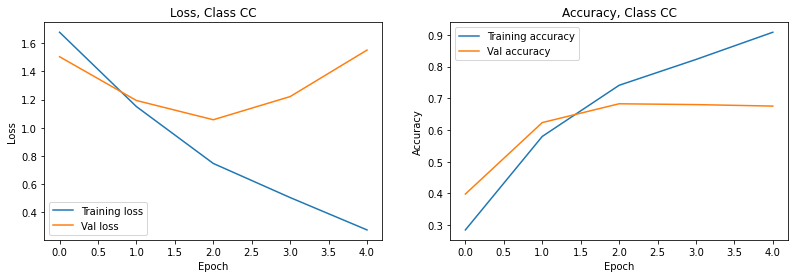

In [18]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Class CC')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Training accuracy')
ax.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Class CC')

plt.show()

## Question 3